# Code for Cahn-Hilliard phase separation with mechanical coupling.


## 2D phase separation study.




Degrees of freedom: 
  - scalar chemical potential: we use normalized  mu = mu/RT 
  - species concentration:  we use normalized  c= Omega*cmat 
  
### Units:
- Length: um
- Mass: kg
- Time: s
- Amount of substance: pmol
- Temperature: K
- Mass density: kg/um^3
- Force: uN
- Stress: MPa
- Energy: pJ
- Species concentration: pmol/um^3
- Chemical potential: pJ/pmol
- Molar volume: um^3/pmol
- Species diffusivity: um^2/s
- Boltzmann Constant: 1.38E-11 pJ/K
- Gas constant: 8.314  pJ/(pmol K)

### By
  Eric Stewart      and      Lallit Anand
ericstew@mit.edu            anand@mit.edu

October 2023

Modified for FenicsX by Jorge Nin
jorgenin@mit.edu

In [1]:
import numpy as np


from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log, default_scalar_type
from dolfinx.fem import Constant, dirichletbc, Function, FunctionSpace, Expression
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter

import ufl
from ufl import (
    TestFunction,
    TrialFunction,
    Identity,
    grad,
    det,
    div,
    dev,
    inv,
    tr,
    sqrt,
    conditional,
    gt,
    dx,
    inner,
    derivative,
    dot,
    ln,
    split,
    tanh,
    as_tensor,
    as_vector,
    ge
)

from hilliard_models import Cahn_Hillard_axi_symmetric
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista

pyvista.set_jupyter_backend("client")
## Define temporal parameters
import random
import gmsh

# DEFINE GEOMETRY

In [2]:
problemName = "Canh Hillard Mechanical Axi Symetric Oval Fast Ramp"
a = .5 #Semi major axis
b = .3 #Semi minor axis
lc = .01
points = [ [0,0],[0,a],[b,0]]
mesh_comm = MPI.COMM_WORLD
model_rank = 0


    
if mesh_comm.rank == model_rank:
    
    gmsh.initialize()
    gmsh.model.add("oval")
    meshpoints = []
    for point in points: 
        #print(point)
        meshpoints.append( gmsh.model.geo.add_point(point[0],point[1],0,lc))
    

    l3 = gmsh.model.geo.add_ellipse_arc(meshpoints[1],meshpoints[0], meshpoints[1], meshpoints[2])
    l1 = gmsh.model.geo.add_line(meshpoints[0], meshpoints[1])
    l2 = gmsh.model.geo.add_line(meshpoints[2], meshpoints[0])
    #l3 =gmsh.model.geo.add_line(meshpoints[2], meshpoints[0])
    
    loop = gmsh.model.geo.add_curve_loop([l1, l2, l3])
    
    surface = gmsh.model.geo.addPlaneSurface([1],1)
    
    
    gdim =2
    
    gmsh.model.geo.synchronize()
    
    gmsh.model.addPhysicalGroup(2, [surface],name="My Surface")
    
    BOTTOM_TAG, LEFT_TAG, OUTSIDE_TAG = 1, 2, 3
    gmsh.model.addPhysicalGroup(1,[l2],BOTTOM_TAG,"Bottom")
    gmsh.model.addPhysicalGroup(1,[l3],OUTSIDE_TAG,"Outside")
    gmsh.model.addPhysicalGroup(1,[l1],LEFT_TAG,"Left")
    
    
    gmsh.model.mesh.generate(2)
    

    
    gmsh.write("mesh/oval.msh")
    gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 40%] Meshing curve 2 (Line)
Info    : [ 70%] Meshing curve 3 (Line)
Info    : Done meshing 1D (Wall 0.00125217s, CPU 0.001391s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0225239s, CPU 0.022183s)
Info    : 1460 nodes 2921 elements
Info    : Writing 'mesh/oval.msh'...
Info    : Done writing 'mesh/oval.msh'


## Read the Mesh and Visualize it

In [3]:
from dolfinx.io.gmshio import read_from_msh
domain, cell_tags, facet_tags = read_from_msh("mesh/oval.msh", MPI.COMM_WORLD, 0,gdim=2)
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)



bottom_mesh = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==BOTTOM_TAG]) )
left_mesh = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==LEFT_TAG]) )
outside_mesh = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==OUTSIDE_TAG]) )


actor = plotter.add_mesh(bottom_mesh, show_edges=True,color="blue")
actor2 = plotter.add_mesh(left_mesh, show_edges=True,color="red")
actor3 = plotter.add_mesh(outside_mesh, show_edges=True,color="green")

plotter.show()
plotter.view_xy()
plotter.close()

Info    : Reading 'mesh/oval.msh'...
Info    : 7 entities
Info    : 1460 nodes
Info    : 2918 elements
Info    : Done reading 'mesh/oval.msh'


Widget(value="<iframe src='http://localhost:50071/index.html?ui=P_0x2a6f9a310_0&reconnect=auto' style='width: …

# Simulation Time Control

In [4]:
t = 0.0  # initialization of time
Ttot = 30  # total simulation time
dt = 0.05  # Initial time step size, here we will use adaptive time-stepping

# Create Problem

In [5]:
dk = Constant(domain,dt)

cri = 0.005
crf = 0.995
def InitFunction(hillard_problem : Cahn_Hillard_axi_symmetric):

    # Some quick definitions to init random values
    V, _ = hillard_problem.ME.sub(1).collapse()
    cBar_init = Function(V)

    cBar_init.interpolate(
        lambda x: np.full_like(x[1],cri)
    ) 

    fc_rand =  (
        ln(cBar_init / (1 - cBar_init)) + hillard_problem.chi * (1 - 2 * cBar_init)
    )  # use that relation to initate the two different sub expressions

    concentration = Expression(
        hillard_problem.Omega*hillard_problem.cMax*cri,
        hillard_problem.ME.sub(2).element.interpolation_points(),
    )
    hillard_problem.w.sub(2).interpolate(concentration)

    chemical_potential = Expression(
        fc_rand , hillard_problem.ME.sub(1).element.interpolation_points()
    )
    hillard_problem.w.sub(1).interpolate(chemical_potential)

    hillard_problem.w.sub(0).interpolate(lambda x: np.zeros((2, x.shape[1])))

    hillard_problem.w_old.x.array[:] = hillard_problem.w.x.array
    hillard_problem.w_old_2.x.array[:] = hillard_problem.w.x.array

hillard_problem = Cahn_Hillard_axi_symmetric(domain,init_func=InitFunction)
hillard_problem.Kinematics()
hillard_problem.WeakForms(dk)

# Setup Output Files

In [6]:
U1 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 1)
V2 = fem.FunctionSpace(domain, U1)#Vector function space
V1 = fem.FunctionSpace(domain, hillard_problem.P1)#Scalar function space

u_vis = Function(V2)
u_vis.name = "u"
u_expr = Expression(hillard_problem.u,V2.element.interpolation_points())


mu_vis = Function(V1)
mu_vis.name = "mu"
mu_expr = Expression(hillard_problem.mu,V1.element.interpolation_points())

c_vis = Function(V1)
c_vis.name = "c"
c_expr = Expression(hillard_problem.c,V1.element.interpolation_points())


T = hillard_problem.T #Cauchy Stress
T2D = as_tensor([[T[0,0], T[0,1]],
                                    [T[1,0], T[1,1]]])

sigma1, sigma2, vec1, vec2 = hillard_problem.eigs(T2D)

sigma1_vis = Function(V1)
sigma1_vis.name = "sigma1"
sigma1_expr = Expression(sigma1,V1.element.interpolation_points())

sigma2_vis = Function(V1)
sigma2_vis.name = "sigma2"
sigma2_expr = Expression(sigma2,V1.element.interpolation_points())


#vtk2 = VTXWriter(domain.comm,"results/"+problemName+"displacement.bp", [u_vis], engine="BP4" )

vtk = VTXWriter(domain.comm,"results/"+problemName+".bp", [u_vis,mu_vis,c_vis,sigma1_vis,sigma2_vis], engine="BP4" )

files = [vtk]

def interp_and_save(t, files: list[VTXWriter]):
    u_vis.interpolate(u_expr)
    mu_vis.interpolate(mu_expr)
    c_vis.interpolate(c_expr)
    sigma2_vis.interpolate(sigma2_expr)
    sigma1_vis.interpolate(sigma1_expr)

    for file in files:
        file.write(t)



# Boundary Conditions

In [7]:
# Just fix the sides to make sure they don't move

u_bc = np.array((0), dtype=default_scalar_type)




left_dofs = fem.locate_dofs_topological(hillard_problem.ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(LEFT_TAG)) #we don't want it to move in the x direction
bottom_dofs = fem.locate_dofs_topological(hillard_problem.ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(BOTTOM_TAG)) #we don't want it to move in the y direction
bcs = [fem.dirichletbc(u_bc, left_dofs, hillard_problem.ME.sub(0).sub(0)),
       fem.dirichletbc(u_bc, bottom_dofs, hillard_problem.ME.sub(0).sub(1))]


In [8]:
#Adding J external boundary condition
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags,metadata={'quadrature_degree': 4})


ui = np.log(cri/(1-cri)) + float(hillard_problem.chi)*(1-2*cri)
uf = np.log(crf/(1-crf)) + float(hillard_problem.chi)*(1-2*crf)


# Fast ramp
def j_func(t):
    return np.min([(ui + (uf-ui)*t/1),uf])


mu_ext = Constant(domain,j_func(0.0))

Jres =  dot(hillard_problem.Omega*(hillard_problem.mu-mu_ext),hillard_problem.mu_test)*hillard_problem.x[0]*ds(OUTSIDE_TAG)

hillard_problem.Res += Jres
hillard_problem.a = derivative(hillard_problem.Res, hillard_problem.w, hillard_problem.dw)



In [9]:
np.sum(hillard_problem.w.sub(1).collapse().x.array - j_func(0.0))

0.0

In [10]:
dx = ufl.dx(metadata={"quadrature_degree": 4})

VolumetricCharge =fem.form(hillard_problem.cBar*hillard_problem.x[0]*dx)
Volume =fem.form(hillard_problem.x[0]*dx)


In [11]:
from dolfinx.fem.petsc import assemble_matrix, create_matrix, create_vector
import sys
from slepc4py import SLEPc

def CalcCond():
    jacobian = fem.form(hillard_problem.a)
    Residual = fem.form(hillard_problem.Res)
    A = create_matrix(jacobian)
    L = create_vector(Residual)

    assemble_matrix(A, jacobian, bcs=bcs)
    A.assemble()

    eigenSolver = SLEPc.EPS()
    eigenSolver.create(comm=mesh_comm)
    eigenSolver.which=SLEPc.EPS.Which.SMALLEST_REAL
    eigenSolver.setOperators(A)

    eigenSolver.solve()
    eigen_min = eigenSolver.getEigenvalue(0)

    eigenSolver.which=SLEPc.EPS.Which.LARGEST_REAL
    eigenSolver.solve()
    eigen_max = eigenSolver.getEigenvalue(0)
    
    
    return eigen_max/eigen_min
    

# Setup Nonlinear Problem

In [12]:
import os
step = "Swell"
jit_options ={"cffi_extra_compile_args":["-O3","-ffast-math"]}

problem = NonlinearProblem(hillard_problem.Res,hillard_problem.w, bcs, hillard_problem.a,jit_options=jit_options)


solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 30
solver.report = True
solver.error_on_nonconvergence = False

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_max_it"] = 30
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

startTime = datetime.now()
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

step = "Evolve"

#if os.path.exists("results/"+problemName+".bp"):
#    os.remove("results/"+problemName+".xdmf")
#    os.remove("results/"+problemName+".h5")

#vtk.write_mesh(domain)
t = 0.0
#log.set_log_level(log.LogLevel.INFO)
interp_and_save(t, files)
ii = 0
bisection_count = 0

volumes = []
charges = []
times=[]
conditions = []
lasttimestep = hillard_problem.w_old_2.x.array.copy()
while t < .1:
    # increment time
    t += float(dk) 
    # increment counter
    ii +=1
    mu_ext.value = j_func(t)
    

    # Solve the problem
    
    (iter, converged) = solver.solve(hillard_problem.w)
    
    if converged and iter < 8:
        hillard_problem.w.x.scatter_forward()
        try:
            conditions.append(CalcCond())
        except:
            conditions.append(0)
            print("error with condition")
        charges.append(fem.assemble_scalar(VolumetricCharge))
        volumes.append(fem.assemble_scalar(Volume))
        times.append(t)
        lasttimestep[:] = hillard_problem.w_old_2.x.array
        hillard_problem.w_old_2.x.array[:] = hillard_problem.w_old.x.array
        hillard_problem.w_old.x.array[:] = hillard_problem.w.x.array
        
        
        
        interp_and_save(t, files)
        if ii % 1 == 0:
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
            print(f"Simulation Time: {t:.2f} s | dt: {dt:.4f}s | cond {conditions[-1]:.2f}")
            print()
        
        if iter <= 3:
            dt = 1.5 * dt
            dk.value = dt
        # If the newton solver takes 5 or more iterations,
        # decrease the time step by a factor of 2:
        elif iter >= 6:
            dt = dt / 2
            dk.value =dt
        
        #Reset Biseciton Counter
        bisection_count = 0
        
    else:
     # Break the loop if solver fails too many times
        bisection_count += 1
        
        if bisection_count > 10:
            print("Error: Too many bisections")
            break
        
        print( "Error Halfing Time Step")
        t = t - float(dk)
        dt = dt / 2
        dk.value = dt
        print(f"New Time Step: {dt}")    
        
        hillard_problem.w.x.array[:] = hillard_problem.w_old.x.array
        hillard_problem.w_old.x.array[:] = hillard_problem.w_old_2.x.array
        hillard_problem.w_old_2.x.array[:] = lasttimestep
        

#End Analysis

for file in files:
    file.close()
endTime = datetime.now()
print("------------------------------------")
print("Simulation End")
print("------------------------------------")
print("Total Time: {}".format(endTime - startTime))
print("------------------------------------")

------------------------------------
Simulation Start
------------------------------------
Step: Evolve |   Increment: 1 | Iterations: 5
Simulation Time: 0.05 s | dt: 0.0500s | cond -139.21-0.00j

Step: Evolve |   Increment: 2 | Iterations: 5
Simulation Time: 0.10 s | dt: 0.0500s | cond -155.84-0.00j

------------------------------------
Simulation End
------------------------------------
Total Time: 0:00:01.609802
------------------------------------


In [13]:

C_res =fem.assemble_vector(fem.form(hillard_problem.Res_c))
mu_res = fem.assemble_vector(fem.form(hillard_problem.Res_mu))
u_res = fem.assemble_vector(fem.form(hillard_problem.Res_u))
FinalRes = fem.assemble_vector(fem.form(hillard_problem.Res))

mu_ext.value =  0
fem.set_bc(C_res.array,bcs)
fem.set_bc(mu_res.array,bcs)
fem.set_bc(u_res.array,bcs)
fem.set_bc(FinalRes.array,bcs)
#Print norms for different vectors
print(f"Final norm is {FinalRes.norm()}")
print(f"Norm for C {C_res.norm()}")
print(f"Norm for mu {mu_res.norm()}")
print(f"Norm for u {u_res.norm()}")


Final norm is 9.762994844865604e-07
Norm for C 4.80629297747124e-19
Norm for mu 1.7084383450774733e-06
Norm for u 4.086291500164552e-17


In [14]:
mu_ext.value = j_func(t)
Jres2 = dot(hillard_problem.Omega*(hillard_problem.mu-mu_ext),hillard_problem.mu_test)*hillard_problem.x[0]*ds(OUTSIDE_TAG)

Boundary = fem.assemble_vector(fem.form( Jres2))
print(f"Boundary Value {Boundary.norm()}")

Boundary Value 1.7957769676309322e-06


In [39]:
V, MEtoV = hillard_problem.ME.sub(1).collapse()
u = Function(V)
T = hillard_problem.Tr* hillard_problem.F.T/hillard_problem.J
#TVal= Expression(mu_res,V.element.interpolation_points())
#u.interpolate(TVal)
u.x.array[:] = mu_res.array[MEtoV]

In [40]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(*vtkdata)

actor = plotter.add_mesh(grid, show_edges=True,scalars=u.x.array)

plotter.show()
plotter.view_xy()
plotter.close()

Widget(value="<iframe src='http://localhost:50071/index.html?ui=P_0x3bbc0f150_5&reconnect=auto' style='width: …

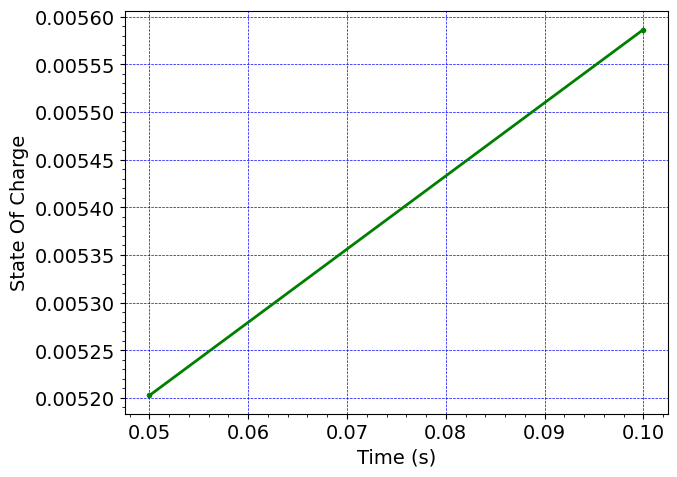

In [17]:
import matplotlib.pyplot as plt

font = {'size'   : 14}
plt.rc('font', **font)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


SOC = np.divide(charges,volumes)
fig = plt.figure()
ax = fig.gca()

plt.plot(times, SOC, linewidth=2.0,\
         color='g', marker='.')

plt.axis('tight')
plt.ylabel(r'State Of Charge')
plt.xlabel(r'Time (s)')

plt.grid(linestyle="--", linewidth=0.5, color='b')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/"+problemName+".png", dpi=600)
plt.show()

In [18]:
arr = solver.A[:,:]

In [19]:
import matplotlib

  cmap = matplotlib.cm.get_cmap("OrRd").copy()



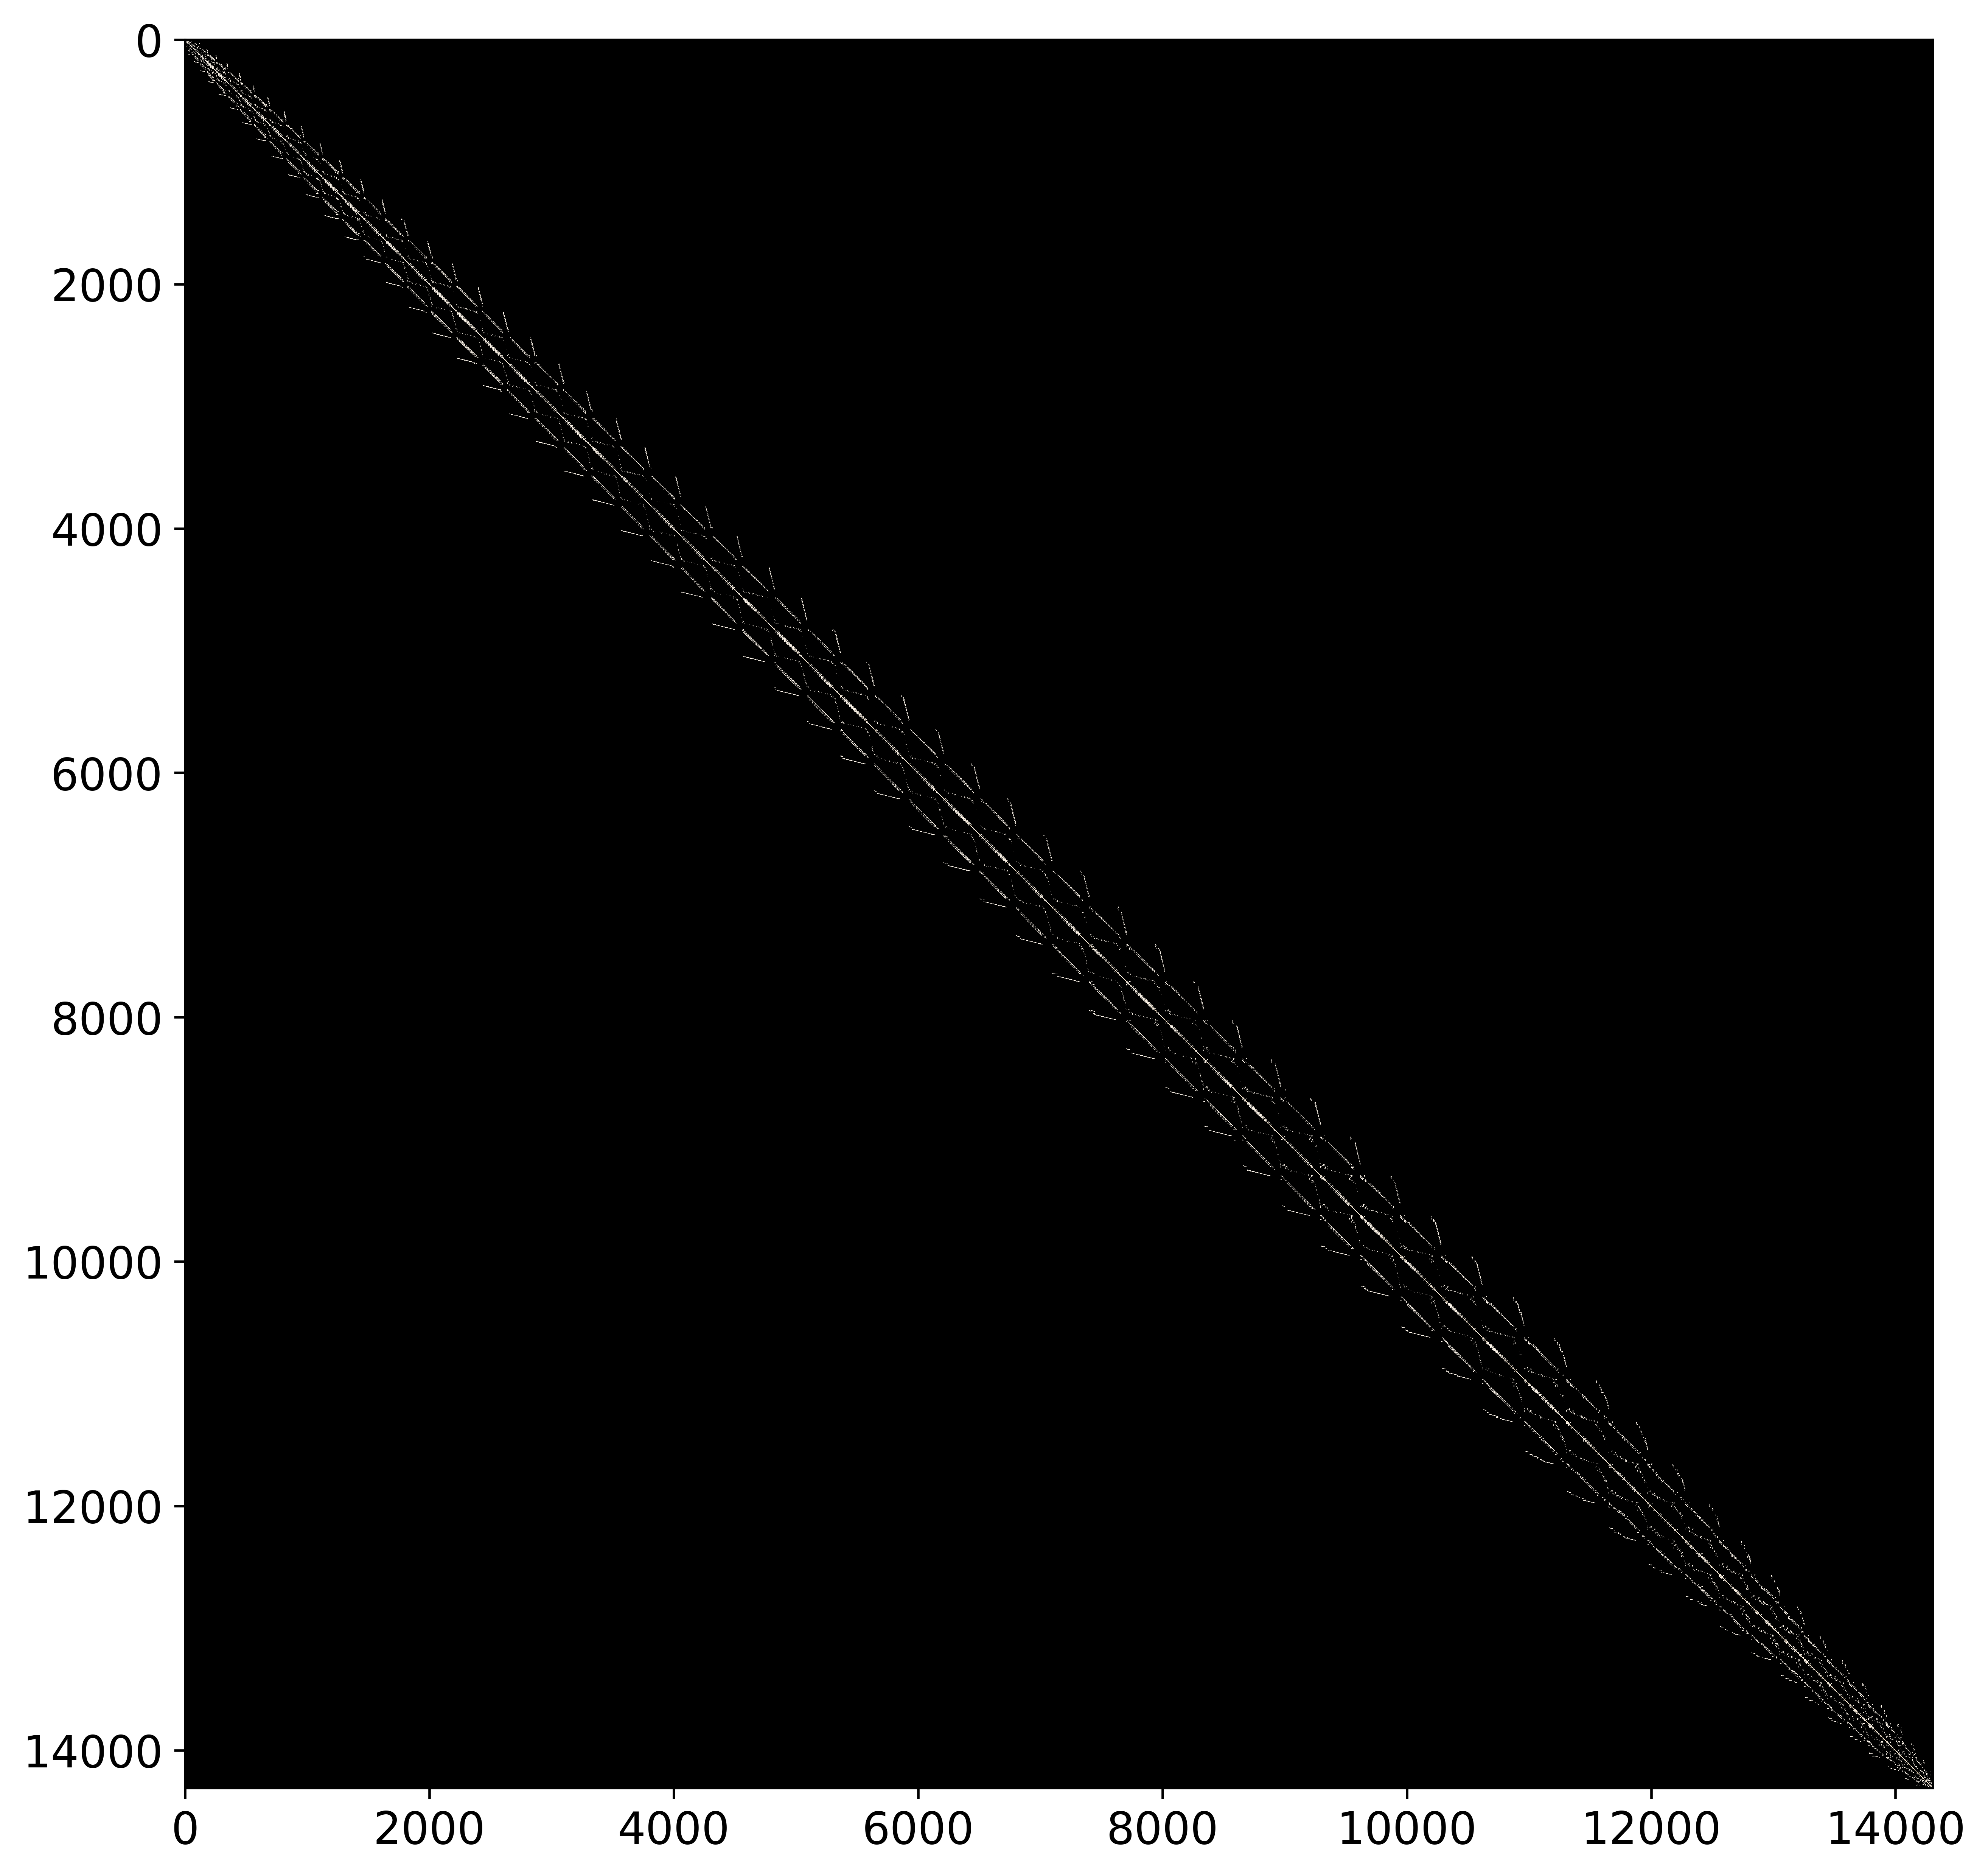

In [20]:
cmap = matplotlib.cm.get_cmap("OrRd").copy()

cmap.set_under(color='black')    

figure = plt.figure(figsize=(10,10),dpi = 600)
plt.imshow(arr, cmap=cmap, vmin=0.0000001)
